# Débugagge

In [27]:
import numpy as np
import matplotlib.pyplot as plt

##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a1 = 2e-3
a2 = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 1000
I = 2**8
L = I * deltaX
H = 2*L
h = 1e-2

d = L//8
K1 = (L//2-d)//deltaX
K2 = (L//2+d)//deltaX

alpha1 = a1/b 
alpha2 = a2/b
beta = eta*v0/(b*sigma) #=6e-08
gamma = mu*dc/(b*sigma*H)

##Calcul du gradient de la transformée de Hilbert (cf. doc)
def noyau(freq,H) :
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2*H*c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)*2*np.pi
    K = noyau(freq, H)
    F=K*F
    psi=np.fft.ifft(F)
    return psi.real*Lb

In [28]:
def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        print(erreur)
        if erreur < tol:
            return ykk, s*h
        if s*h < dtmin:
            return ykk, h
        h = s*h
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

In [29]:
def F(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    phidot = (v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1)))/(alpha1+beta*v)
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def G(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    D = v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1))
    phid1 = D/(alpha1 + beta*v)
    phid2 = D/(alpha2 + beta*v)
    phidot = np.concatenate((phid1[0:K1], phid2[K1:K2+1], phid1[K2+1:]))
    nudot = 1/theta - v
    return np.array([phidot, nudot])

In [30]:
x = np.arange(-L//2, L//2 + 1, deltaX)
temps = np.array([0])
amp = 100
CI = amp*np.ones(len(x))

phik = np.log(CI)
nuk = np.log(1/CI)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(G, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [temps[n]+h]))
    Phi.append(yk[0])
    Nu.append(yk[1])

17169.17514734198
1.906999940500488e-14
2.6881156767937775e-14
2.454634323326545e-10
3.273056299936245e-11
4.792632064986176e-11
4.26698028033797e-11
4.4014711194632804e-11
4.346483975852273e-11
4.349990612289519e-11
4.3390770695079446e-11
4.3372021640512875e-11
4.339930069311306e-11
4.3535622130825017e-11
4.380795820364032e-11
4.427729983600576e-11
4.497883662170038e-11
4.5923247136718126e-11
4.702683036411298e-11
4.815938031595472e-11
4.916796930102517e-11
4.9961901461152985e-11
5.053127958053617e-11
5.0905649320945106e-11
5.114224192843816e-11
5.128461787316746e-11
5.136302555377279e-11
5.140247180874816e-11
5.1422078630455704e-11
5.142299323903896e-11
5.141681426962402e-11
5.139942384607764e-11
5.138532150164871e-11
5.1361625020447574e-11
5.134237626618384e-11
5.131380607507122e-11
5.1293688408373124e-11
5.126682599096467e-11
5.124208315269946e-11
5.12173750993285e-11
5.118772105962036e-11
5.116192701517172e-11
5.1135474765320565e-11
5.11086706301497e-11
5.108177761603648e-11
5.105

4.98475080807292e-11
4.979104197048548e-11
4.9729499014096515e-11
4.9671955576039356e-11
4.960390319796381e-11
4.9540254844934257e-11
4.946913742281698e-11
4.9396421891399155e-11
4.931788429035204e-11
4.9235515173992516e-11
4.914503901794309e-11
4.90507288961366e-11
4.894569373990101e-11
4.883355791774322e-11
4.8710397505976495e-11
4.85724716963521e-11
4.842225951322389e-11
4.825230467073454e-11
4.806184198902279e-11
4.784498404012389e-11
4.7598713459691424e-11
4.7318284760079136e-11
4.699282704276895e-11
4.662478355087572e-11
4.6211555043270885e-11
4.5778101502606584e-11
4.538580305284344e-11
4.5227520565009884e-11
4.573400824689463e-11
4.763922056763654e-11
5.128254495151581e-11
5.512358766430771e-11
5.706842525913685e-11
5.7259964330154766e-11
5.674008830427353e-11
5.606116168658362e-11
5.542007495303858e-11
5.486244604680439e-11
5.439057436625573e-11
5.398835533314504e-11
5.364772727685783e-11
5.335598232011347e-11
5.310238465897203e-11
5.288218852709822e-11
5.268630267726967e-11
5

4.7281373206364866e-11
4.713903644260634e-11
4.70270512216391e-11
4.698521673144569e-11
4.707910520528019e-11
4.7408312238303887e-11
4.8094134228931166e-11
4.9213714939819014e-11
5.0692286294812576e-11
5.222816929862236e-11
5.346466595760919e-11
5.4222340509571234e-11
5.4555396345919515e-11
5.45989824719129e-11
5.449070174182672e-11
5.430362845948189e-11
5.409531505251271e-11
5.388193330273388e-11
5.3679379321904495e-11
5.349237946892158e-11
5.332075947159886e-11
5.316457219074098e-11
5.302209993071205e-11
5.289488341128977e-11
5.27758804700777e-11
5.267107011288603e-11
5.257328247806498e-11
5.248102820359257e-11
5.2402011100691706e-11
5.232035187098729e-11
5.225281865865535e-11
5.2183744315378187e-11
5.2123292530479435e-11
5.206190006741758e-11
5.200843447037693e-11
5.1955287260801356e-11
5.1905668863670475e-11
5.1858397179557577e-11
5.1813347075785964e-11
5.176985055647863e-11
5.172820047828023e-11
5.168910780409627e-11
5.165036307048662e-11
5.1612951792928046e-11
5.157706513043446e-

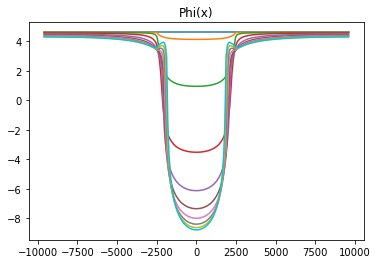

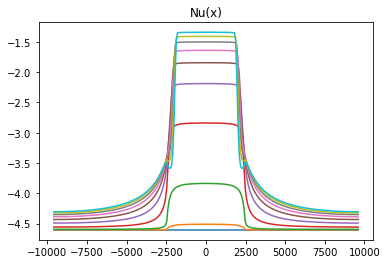

In [31]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, Phi[n])
plt.title('Phi(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, Nu[n])
plt.title('Nu(x)')
plt.show()

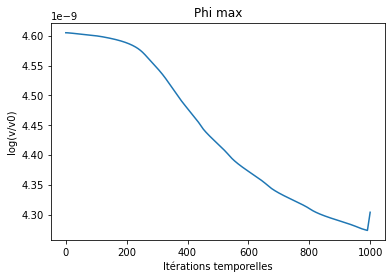

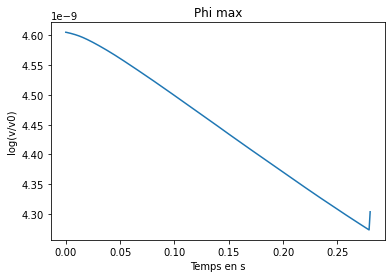

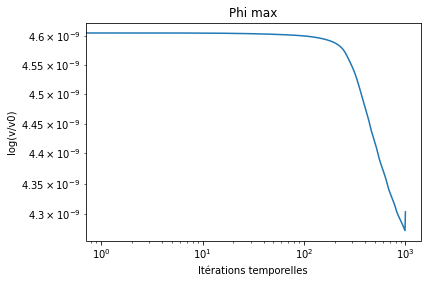

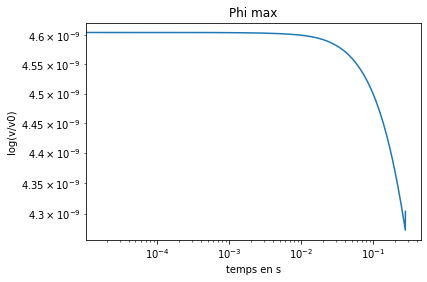

In [32]:
Mphi = np.array([np.max(f) for f in Phi])
t = np.arange(len(Mphi))
plt.plot(t, Mphi*v0)
plt.title('Phi max')
plt.xlabel('Itérations temporelles')
plt.ylabel('log(v/v0)')
plt.show()
plt.plot(temps, Mphi*v0)
plt.title('Phi max')
plt.xlabel('Temps en s')
plt.ylabel('log(v/v0)')
plt.show()
plt.loglog(t, Mphi*v0)
plt.title('Phi max')
plt.xlabel('Itérations temporelles')
plt.ylabel('log(v/v0)')
plt.show()
plt.loglog(temps, Mphi*v0)
plt.title('Phi max')
plt.xlabel('temps en s')
plt.ylabel('log(v/v0)')
plt.show()

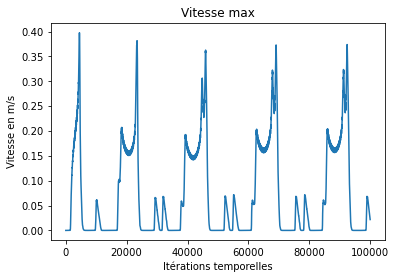

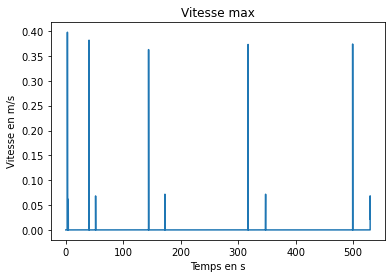

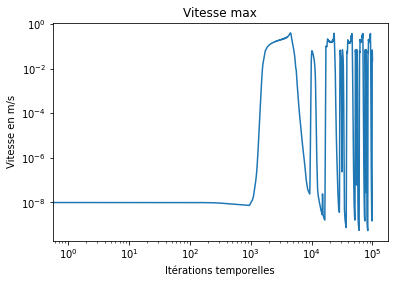

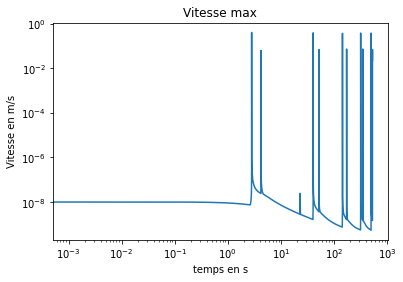

In [23]:
Mphi = np.array([np.max(f) for f in np.exp(Phi)])
t = np.arange(len(Mphi))
plt.plot(t, Mphi*v0)
plt.title('Vitesse max')
plt.xlabel('Itérations temporelles')
plt.ylabel('Vitesse en m/s')
plt.show()
plt.plot(temps, Mphi*v0)
plt.title('Vitesse max')
plt.xlabel('Temps en s')
plt.ylabel('Vitesse en m/s')
plt.show()
plt.loglog(t, Mphi*v0)
plt.title('Vitesse max')
plt.xlabel('Itérations temporelles')
plt.ylabel('Vitesse en m/s')
plt.show()
plt.loglog(temps, Mphi*v0)
plt.title('Vitesse max')
plt.xlabel('temps en s')
plt.ylabel('Vitesse en m/s')
plt.show()